In [ ]:
#https://drive.google.com/file/d/1S6ill5dSh09-NV1qlbgFjKxCw7vsxgr2/view?usp=sharing
!gdown 1S6ill5dSh09-NV1qlbgFjKxCw7vsxgr2

Downloading...
From: https://drive.google.com/uc?id=1S6ill5dSh09-NV1qlbgFjKxCw7vsxgr2
To: /content/thecut[en]-2018.txt
100% 73.8M/73.8M [00:00<00:00, 249MB/s]


In [ ]:
import numpy as np
import pandas as pd
from collections import Counter

from nltk.tokenize import word_tokenize
import re, string
import nltk

from tqdm import tqdm
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

nltk.download('stopwords')
from nltk.corpus import stopwords
sw_eng = set(stopwords.words('english'))

from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer

!pip install bigartm
import artm

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
sns.set(style="ticks")
sns.set_style("darkgrid")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.0 MB/s 


# **Creating a DataFrame**

In [ ]:
with open('thecut[en]-2018.txt') as f:
    thecut = " ".join(line.strip() for line in f)  

articles = thecut.split("----------")

In [ ]:
month = []
day = []
year = []

for article in articles:
  m = article.split()[0:1]
  if m == []:
    month.append(np.nan)
  else:
    month.append(''.join(m))

  d = article.split()[1:2]
  if d == [] or d == ['A.M.'] or d == ['P.M.']:
    day.append(np.nan)
  else:
    day.append(int((''.join(d))[0:-1]))
  
  y = article.split()[2:3]
  if y == [] or y == ['The'] or y == ['Meghan'] or y == ['My']:
    year.append(np.nan)
  else:
    year.append(int(''.join(y)))

In [ ]:
data = pd.DataFrame(
    {'month': month,
     'day': day,
     'year': year,
     'text': articles
    })

data

,month,day,year,text
0,NaN,NaN,NaN,
1,10:23,NaN,NaN,10:23 A.M. The Met Gift Shop Has Gone Bananas...
2,May,3.0,2019.0,"May 3, 2019 Rei Kawakubo Is ‘Not Interested’ ..."
3,May,3.0,2019.0,"May 3, 2019 Francisco Costa Is a Minimalist E..."
4,May,3.0,2019.0,"May 3, 2019 Prada Wants You to Turn Off Your ..."
...,...,...,...,...
28903,May,11.0,2015.0,"May 11, 2015 Watch a Brief Explainer on How A..."
28904,May,11.0,2015.0,"May 11, 2015 More Proof That Gluttony (and Re..."
28905,May,11.0,2015.0,"May 11, 2015 Astrology GIFs for the Week of M..."
28906,May,10.0,2015.0,"May 10, 2015 Do High-Tech Promises Turn Us In..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28908 entries, 0 to 28907
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   month   28260 non-null  object 
 1   day     28257 non-null  float64
 2   year    28257 non-null  float64
 3   text    28908 non-null  object 
dtypes: float64(2), object(2)
memory usage: 903.5+ KB


In [ ]:
data.isna().sum()

month    648
day      651
year     651
text       0
dtype: int64

In [ ]:
data[data.isna().any(axis=1)]

,month,day,year,text
0,NaN,NaN,NaN,
1,10:23,NaN,NaN,10:23 A.M. The Met Gift Shop Has Gone Bananas...
50,NaN,NaN,NaN,
102,NaN,NaN,NaN,
153,NaN,NaN,NaN,
...,...,...,...,...
28673,NaN,NaN,NaN,
28718,NaN,NaN,NaN,
28765,NaN,NaN,NaN,
28814,NaN,NaN,NaN,


In [ ]:
data = data.dropna()
data = data.reset_index(drop=True)
data

,month,day,year,text
0,May,3.0,2019.0,"May 3, 2019 Rei Kawakubo Is ‘Not Interested’ ..."
1,May,3.0,2019.0,"May 3, 2019 Francisco Costa Is a Minimalist E..."
2,May,3.0,2019.0,"May 3, 2019 Prada Wants You to Turn Off Your ..."
3,May,3.0,2019.0,"May 3, 2019 Rihanna’s Creativity Is Stressing..."
4,May,3.0,2019.0,"May 3, 2019 Carine Roitfeld Launches 7 Fragra..."
...,...,...,...,...
28252,May,11.0,2015.0,"May 11, 2015 Watch a Brief Explainer on How A..."
28253,May,11.0,2015.0,"May 11, 2015 More Proof That Gluttony (and Re..."
28254,May,11.0,2015.0,"May 11, 2015 Astrology GIFs for the Week of M..."
28255,May,10.0,2015.0,"May 10, 2015 Do High-Tech Promises Turn Us In..."


In [ ]:
data.isna().sum()

month    0
day      0
year     0
text     0
dtype: int64

# **Data preproccesing**

In [ ]:
Counter(data['month'])

Counter({'Apr.': 2187,
         'April': 123,
         'Aug.': 2109,
         'August': 105,
         'Dec.': 2007,
         'December': 103,
         'Feb.': 2527,
         'February': 184,
         'Jan.': 2047,
         'January': 127,
         'July': 1979,
         'June': 2100,
         'Mar.': 2282,
         'March': 114,
         'May': 2084,
         'Nov.': 2291,
         'November': 135,
         'Oct.': 2567,
         'October': 137,
         'Sept.': 2825,
         'September': 224})

In [ ]:
new_txt = []
for w in range(len(data.month)):
  desc = data.iloc[w]['month']

  if desc == 'Apr.':
    desc = 'April'
    new_txt.append(desc)
  elif desc == 'Aug.':
    desc = 'August'
    new_txt.append(desc)
  elif desc == 'Dec.':
    desc = 'December'
    new_txt.append(desc)
  elif desc == 'Feb.':
    desc = 'February'
    new_txt.append(desc)
  elif desc == 'Jan.':
    desc = 'January'
    new_txt.append(desc)
  elif desc == 'Mar.':
    desc = 'March'
    new_txt.append(desc)
  elif desc == 'Nov.':
    desc = 'November'
    new_txt.append(desc)
  elif desc == 'Oct.':
    desc = 'October'
    new_txt.append(desc)
  elif desc == 'Sept.':
    desc = 'September'
    new_txt.append(desc)
  else:
    new_txt.append(desc)

data['month'] = new_txt

**Очистка текста**

In [ ]:
def removing_punctuation(data):
  clean_txt = []
  for w in range(len(data.text)):
    desc = data.iloc[w]['text'].lower()

    #удаляем пунктуацию
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    desc = regex.sub('', desc)

    clean_txt.append(desc)

  data['clean_text'] = clean_txt
  return data

data = removing_punctuation(data)
data.head()

,month,day,year,text,clean_text
0,May,3.0,2019.0,"May 3, 2019 Rei Kawakubo Is ‘Not Interested’ ...",may 3 2019 rei kawakubo is ‘not interested’ i...
1,May,3.0,2019.0,"May 3, 2019 Francisco Costa Is a Minimalist E...",may 3 2019 francisco costa is a minimalist ev...
2,May,3.0,2019.0,"May 3, 2019 Prada Wants You to Turn Off Your ...",may 3 2019 prada wants you to turn off your b...
3,May,3.0,2019.0,"May 3, 2019 Rihanna’s Creativity Is Stressing...",may 3 2019 rihanna’s creativity is stressing ...
4,May,3.0,2019.0,"May 3, 2019 Carine Roitfeld Launches 7 Fragra...",may 3 2019 carine roitfeld launches 7 fragran...


**Лемматизация**

In [ ]:
# Define function to lemmatize each word with its POS tag
def pos_tagger(nltk_tag):
  if nltk_tag.startswith('J'):
    return wordnet.ADJ
  elif nltk_tag.startswith('V'):
    return wordnet.VERB
  elif nltk_tag.startswith('N'):
    return wordnet.NOUN
  elif nltk_tag.startswith('R'):
    return wordnet.ADV
  else:    
    return None

def my_lemmatizer(sentence):
  lemmatizer = WordNetLemmatizer()

  pos_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
  wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))

  lemmatized_sentence = []
  for word, tag in wordnet_tagged:
    if tag is None:
      # if there is no available tag, append the token as is
      lemmatized_sentence.append(word)
    else:  
      # else use the tag to lemmatize the token
      lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
  lemmatized_sentence = " ".join(lemmatized_sentence)
  return lemmatized_sentence

def lemmatization(data):
  normalized_txt = []
  for w in tqdm(range(len(data.clean_text))):
    sent = data.iloc[w]['clean_text']

    normalized_sent = my_lemmatizer(sent)
    normalized_txt.append(normalized_sent)

  data['clean_text'] = normalized_txt
  return data

data = lemmatization(data)
data.head()

100%|██████████| 28257/28257 [14:09<00:00, 33.28it/s]


,month,day,year,text,clean_text
0,May,3.0,2019.0,"May 3, 2019 Rei Kawakubo Is ‘Not Interested’ ...",may 3 2019 rei kawakubo be ‘ not interested ’ ...
1,May,3.0,2019.0,"May 3, 2019 Francisco Costa Is a Minimalist E...",may 3 2019 francisco costa be a minimalist eve...
2,May,3.0,2019.0,"May 3, 2019 Prada Wants You to Turn Off Your ...",may 3 2019 prada want you to turn off your bra...
3,May,3.0,2019.0,"May 3, 2019 Rihanna’s Creativity Is Stressing...",may 3 2019 rihanna ’ s creativity be stress pe...
4,May,3.0,2019.0,"May 3, 2019 Carine Roitfeld Launches 7 Fragra...",may 3 2019 carine roitfeld launch 7 fragrance ...


**Уменьшение словаря**

In [ ]:
def deleting_stop_words(data):
  clean_txt = []
  for w in range(len(data.clean_text)):
    sent = data.iloc[w]['clean_text']

    clean_sent = ' '.join([word for word in sent.split() if not word in sw_eng])
    clean_txt.append(clean_sent)

  data['clean_text'] = clean_txt
  return data

data = deleting_stop_words(data)
data.head()

,month,day,year,text,clean_text
0,May,3.0,2019.0,"May 3, 2019 Rei Kawakubo Is ‘Not Interested’ ...",may 3 2019 rei kawakubo ‘ interested ’ posteri...
1,May,3.0,2019.0,"May 3, 2019 Francisco Costa Is a Minimalist E...",may 3 2019 francisco costa minimalist even com...
2,May,3.0,2019.0,"May 3, 2019 Prada Wants You to Turn Off Your ...",may 3 2019 prada want turn brain best romantic...
3,May,3.0,2019.0,"May 3, 2019 Rihanna’s Creativity Is Stressing...",may 3 2019 rihanna ’ creativity stress people ...
4,May,3.0,2019.0,"May 3, 2019 Carine Roitfeld Launches 7 Fragra...",may 3 2019 carine roitfeld launch 7 fragrance ...


**Удаление цифр и ненужных символов**

In [ ]:
def text_cleaning(data):
  clean_txt = []
  for w in range(len(data.clean_text)):
    desc = data.iloc[w]['clean_text']

    #удаляем первое слово, так как это всегда месяц
    desc = desc.split(' ', 1)[1]
    
    #удаляем символы
    desc = re.sub('[–\”“‘’!?@#$&%№—]', '', desc)

    #удаляем короткие слова
    desc = ' '.join([word for word in desc.split() if len(word) >= 3])

    #удаляем цифры
    desc = ''.join([i for i in desc if not i.isdigit()])

    clean_txt.append(desc)

  data['clean_text'] = clean_txt
  return data

data = text_cleaning(data)
data.head()

,month,day,year,text,clean_text
0,May,3.0,2019.0,"May 3, 2019 Rei Kawakubo Is ‘Not Interested’ ...",rei kawakubo interested posterity thursday ni...
1,May,3.0,2019.0,"May 3, 2019 Francisco Costa Is a Minimalist E...",francisco costa minimalist even come beauty b...
2,May,3.0,2019.0,"May 3, 2019 Prada Wants You to Turn Off Your ...",prada want turn brain best romantic advice ev...
3,May,3.0,2019.0,"May 3, 2019 Rihanna’s Creativity Is Stressing...",rihanna creativity stress people monday fenty...
4,May,3.0,2019.0,"May 3, 2019 Carine Roitfeld Launches 7 Fragra...",carine roitfeld launch fragrance carine roitf...


In [ ]:
# сохранение файла чтобы не потерять расчёты
from google.colab import files

data.to_csv('data.csv', encoding='utf-8', index=False) 
files.download('data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#https://drive.google.com/file/d/1MRulCS1J5xPrxPXQ99bHQxtgYi0Kt2xJ/view?usp=sharing
!gdown 1MRulCS1J5xPrxPXQ99bHQxtgYi0Kt2xJ

Downloading...
From: https://drive.google.com/uc?id=1MRulCS1J5xPrxPXQ99bHQxtgYi0Kt2xJ
To: /content/data.csv
100% 118M/118M [00:00<00:00, 134MB/s] 


In [ ]:
data = pd.read_csv('data.csv', delimiter=',')
data.head()

,month,day,year,text,clean_text
0,May,3.0,2019.0,"May 3, 2019 Rei Kawakubo Is ‘Not Interested’ ...",rei kawakubo interested posterity thursday ni...
1,May,3.0,2019.0,"May 3, 2019 Francisco Costa Is a Minimalist E...",francisco costa minimalist even come beauty b...
2,May,3.0,2019.0,"May 3, 2019 Prada Wants You to Turn Off Your ...",prada want turn brain best romantic advice ev...
3,May,3.0,2019.0,"May 3, 2019 Rihanna’s Creativity Is Stressing...",rihanna creativity stress people monday fenty...
4,May,3.0,2019.0,"May 3, 2019 Carine Roitfeld Launches 7 Fragra...",carine roitfeld launch fragrance carine roitf...


**Биграммы**

In [ ]:
# def get_ngrams(text, n ):
#     n_grams = ngrams(word_tokenize(text), n)
#     return [' '.join(grams) for grams in n_grams]

In [ ]:
# bigrams = []
# for w in range(len(data.clean_text)):
#   desc = data.iloc[w]['clean_text']
#   bigrams += list(map(lambda x: x[0], list(filter(lambda x: x[1] >= 5, Counter(get_ngrams(desc, 2)).most_common()))))
#   #bigrams += get_ngrams(desc, 2)
    
# bigrams = list(filter(lambda x: 'package' not in x and 'document' not in x, bigrams))
# bigrams = list(map(lambda x: x[0], (list(filter(lambda x: x[1] >= 5, Counter(bigrams).most_common())))))

# print(len(bigrams))
# print(bigrams[:5])

**Разделяем статьи по месяцам**

In [ ]:
#по годам
dfs = [y for x, y in data.groupby('year', as_index=False)]

#месяца по годам
df2008 = [y for x, y in dfs[0].groupby('month', as_index=False)] #2008
df2009 = [y for x, y in dfs[1].groupby('month', as_index=False)]
df2010 = [y for x, y in dfs[2].groupby('month', as_index=False)]
df2011 = [y for x, y in dfs[3].groupby('month', as_index=False)]
df2012 = [y for x, y in dfs[4].groupby('month', as_index=False)]
df2013 = [y for x, y in dfs[5].groupby('month', as_index=False)]
df2014 = [y for x, y in dfs[6].groupby('month', as_index=False)]
df2015 = [y for x, y in dfs[7].groupby('month', as_index=False)]
df2016 = [y for x, y in dfs[8].groupby('month', as_index=False)]
df2017 = [y for x, y in dfs[9].groupby('month', as_index=False)]
df2018 = [y for x, y in dfs[10].groupby('month', as_index=False)]
df2019 = [y for x, y in dfs[11].groupby('month', as_index=False)] #2019

# **ARTM model**

In [ ]:
def to_vw_format(document):
  return '|text ' + ' '.join(word for word in document.split())

def artm_model(data, num_top):
  #Представим данные в специальном формате «vowpal wabbit». Это «мешок слов», где каждая новая строка содержит слова, употребляемые в рамках документа. 
  #Эта информация записывается после тега |text.
  f = open('documents.txt', 'w')
  vw = data.clean_text.apply(to_vw_format)

  for i in range(len(vw)):
    f.write(str(vw.values[i])+ '\n')
  f.close()

  #Разделяем набор данных на специальные части batch
  batch_vect = artm.BatchVectorizer(data_path='documents.txt',
                                    data_format='vowpal_wabbit',
                                    target_folder='batch_vect')
  
  #Cоздаем словарь со всеми словами из всех текстов
  dict = artm.Dictionary()
  dict.gather(data_path='batch_vect')
  dict.save_text(dictionary_path='batch_vect/my_dict.txt')

  #Отфильтруем часто встречающиеся (слова, которые не несут смысловой нагрузки) и редко встречающиеся слова (опечатки, словоформы)
  dict.filter(min_tf=10, max_tf=2000)

  #Выполняем тематическое моделирование
  theme_mod = artm.ARTM(num_topics = num_top, dictionary=dict, cache_theta= True,
                        regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.4)]) 
  #theta – матрица вероятностей принадлежности каждого текста каждой тематике
  #sparsity regularizer(регуляризатор разреженности) для theta-матрицы
  #decorrelator стимулирует разреженность phi
  #(мы добавляем эти регуляризаторы, чтобы сделать темы более понятными)

  theme_mod.scores.add(artm.PerplexityScore(name='my_first_perplexity_score', dictionary=dict)) #метрика оценки модели – перплексия, отражает степень сходимости модели
  theme_mod.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=20)) #метрика оценки модели – топ num_tokens слов  по каждой тематике

  theme_mod.num_document_passes = 70 #число итераций по документу
  theme_mod.initialize(dictionary=dict) #заполняем матрицу Ф снова случайными числами

  theme_mod.fit_offline(batch_vectorizer=batch_vect, num_collection_passes=100) #num_collection_passes – количество итераций по коллекции


  topics = []
  for theme in theme_mod.topic_names:
    topics.append(theme_mod.score_tracker['TopTokensScore'].last_tokens[theme])

  !rm -rf batch_vect

  return topics

In [ ]:
#выбор уникальных тем в каждом месяце
def select_uniq_topics(topics, n):
  uniq_topics = []
  uniq_topics.append(topics[0])

  for i in range(len(topics)):
    for j in range(len(uniq_topics)):
      if len(list(set(uniq_topics[j]) & set(topics[i]))) > n:
        break
    else:
      uniq_topics.append(topics[i])

  return uniq_topics

#добавление уникальных тем по месяцам
def add_uniq_topics(uniq_topics, topics, n):
  for i in range(len(topics)):
    for j in range(len(uniq_topics)):
      if len(list(set(uniq_topics[j]) & set(topics[i]))) > n:
        break
    else:
      uniq_topics.append(topics[i])

  return uniq_topics

In [ ]:
def find_topics_create_matrix(n, 
                              january, february, march, april, may, june,
                              july, august, september, october, november, december):
  
  april = select_uniq_topics(april, n)
  august = select_uniq_topics(august, n)
  december = select_uniq_topics(december, n)
  february = select_uniq_topics(february, n)
  january = select_uniq_topics(january, n)
  july = select_uniq_topics(july, n)
  june = select_uniq_topics(june, n)
  march = select_uniq_topics(march, n)
  may = select_uniq_topics(may, n)
  november = select_uniq_topics(november, n)
  october = select_uniq_topics(october, n)
  september = select_uniq_topics(september, n)

  uniq_topics = january.copy()

  uniq_topics = add_uniq_topics(uniq_topics, february, n)
  uniq_topics = add_uniq_topics(uniq_topics, march, n)
  uniq_topics = add_uniq_topics(uniq_topics, april, n)
  uniq_topics = add_uniq_topics(uniq_topics, may, n)
  uniq_topics = add_uniq_topics(uniq_topics, june, n)
  uniq_topics = add_uniq_topics(uniq_topics, july, n)
  uniq_topics = add_uniq_topics(uniq_topics, august, n)
  uniq_topics = add_uniq_topics(uniq_topics, september, n)
  uniq_topics = add_uniq_topics(uniq_topics, october, n)
  uniq_topics = add_uniq_topics(uniq_topics, november, n)
  uniq_topics = add_uniq_topics(uniq_topics, december, n)

  uniq_topics_new, title = [], []
  title.append(uniq_topics[0][0:3])
  uniq_topics_new.append(uniq_topics[0])

  for i in range(len(uniq_topics)):
    for j in range(len(title)):
      if len(list(set(title[j]) & set(uniq_topics[i][0:3]))) > 1:
        break
    else:
      title.append(uniq_topics[i][0:3])
      uniq_topics_new.append(uniq_topics[i])

  uniq_topics = uniq_topics_new.copy()


  #создание матрицы
  matr = np.zeros(shape=(len(uniq_topics), 12))
  matr.fill(np.nan)
  count = 0

  for theme in range(len(uniq_topics)):
    count += 1
    for i in range(len(january)):
      if len(list(set(uniq_topics[theme]) & set(january[i]))) > n:
        matr[theme, 0] = count

    for i in range(len(february)):
      if len(list(set(uniq_topics[theme]) & set(february[i]))) > n:
        matr[theme, 1] = count

    for i in range(len(march)):
      if len(list(set(uniq_topics[theme]) & set(march[i]))) > n:
        matr[theme, 2] = count

    for i in range(len(april)):
      if len(list(set(uniq_topics[theme]) & set(april[i]))) > n:
        matr[theme, 3] = count

    for i in range(len(may)):
      if len(list(set(uniq_topics[theme]) & set(may[i]))) > n:
        matr[theme, 4] = count

    for i in range(len(june)):
      if len(list(set(uniq_topics[theme]) & set(june[i]))) > n:
        matr[theme, 5] = count

    for i in range(len(july)):
      if len(list(set(uniq_topics[theme]) & set(july[i]))) > n:
        matr[theme, 6] = count

    for i in range(len(august)):
      if len(list(set(uniq_topics[theme]) & set(august[i]))) > n:
        matr[theme, 7] = count

    for i in range(len(september)):
      if len(list(set(uniq_topics[theme]) & set(september[i]))) > n:
        matr[theme, 8] = count

    for i in range(len(october)):
      if len(list(set(uniq_topics[theme]) & set(october[i]))) > n:
        matr[theme, 9] = count

    for i in range(len(november)):
      if len(list(set(uniq_topics[theme]) & set(november[i]))) > n:
        matr[theme, 10] = count

    for i in range(len(december)):
      if len(list(set(uniq_topics[theme]) & set(december[i]))) > n:
        matr[theme, 11] = count

  return uniq_topics, matr

In [ ]:
def draw_graph(uniq_topics, matr, months, wid, hei):
  topic_titles = []
  for i in range(len(uniq_topics)):
    topic_titles.append(', '.join(uniq_topics[i][0:3]))
  topic_titles.insert(0, '')

  X = np.arange(len(months))
  iter_uniq_topics = np.arange(len(uniq_topics))
  colors = cm.rainbow(np.linspace(0, 1, len(iter_uniq_topics)))

  plt.figure(figsize=(wid, hei))
  for i, c in zip(iter_uniq_topics, colors):
    plt.scatter(X, matr[i], color = c, s = 150)
    
  plt.xlabel('Months')
  plt.ylabel('Topics')
  plt.title('Article topics for the year')

  XclassNames = [i for i in months]
  YclassNames = [i for i in topic_titles]
  Xtick_marks = np.arange(len(XclassNames))
  Ytick_marks = np.arange(len(YclassNames))
  plt.xticks(Xtick_marks, XclassNames, rotation=45)
  plt.yticks(Ytick_marks, YclassNames)
    
  plt.show()



---



**2008 год**

выполняем тематическое моделивание каждого месяца в году

In [ ]:
topics_august = artm_model(df2008[0], 8)
topics_december = artm_model(df2008[1], 15)
topics_november = artm_model(df2008[2], 20)
topics_october = artm_model(df2008[3], 20)
topics_september = artm_model(df2008[4], 20)

отбираем уникальные темы в каждом месяце

In [ ]:
threshold = 7

topics_august = select_uniq_topics(topics_august, threshold)
topics_december = select_uniq_topics(topics_december, threshold)
topics_november = select_uniq_topics(topics_november, threshold)
topics_october = select_uniq_topics(topics_october, threshold)
topics_september = select_uniq_topics(topics_september, threshold)

собираем список уникальных тематик за весь год

In [ ]:
unique_topics = topics_august.copy()

unique_topics = add_uniq_topics(unique_topics, topics_september, threshold)
unique_topics = add_uniq_topics(unique_topics, topics_october, threshold)
unique_topics = add_uniq_topics(unique_topics, topics_november, threshold)
unique_topics = add_uniq_topics(unique_topics, topics_december, threshold)


uniq_topics_new, titles = [], []
titles.append(unique_topics[0][0:3])
uniq_topics_new.append(unique_topics[0])

for i in range(len(unique_topics)):
  for j in range(len(titles)):
    if len(list(set(titles[j]) & set(unique_topics[i][0:3]))) > 1:
      break
  else:
    titles.append(unique_topics[i][0:3])
    uniq_topics_new.append(unique_topics[i])

unique_topics = uniq_topics_new.copy()
print('Количество уникальных тем за год:', len(unique_topics))

Количество уникальных тем за год: 36


создаём матрицу для построения графика

In [ ]:
matrix = np.zeros(shape=(len(unique_topics), 5))
matrix.fill(np.nan)
count = 0

for theme in range(len(unique_topics)):
  count += 1
  for i in range(len(topics_august)):
    if len(list(set(unique_topics[theme]) & set(topics_august[i]))) > threshold:
      matrix[theme, 0] = count

  for i in range(len(topics_september)):
    if len(list(set(unique_topics[theme]) & set(topics_september[i]))) > threshold:
      matrix[theme, 1] = count

  for i in range(len(topics_october)):
    if len(list(set(unique_topics[theme]) & set(topics_october[i]))) > threshold:
      matrix[theme, 2] = count

  for i in range(len(topics_november)):
    if len(list(set(unique_topics[theme]) & set(topics_november[i]))) > threshold:
      matrix[theme, 3] = count

  for i in range(len(topics_december)):
    if len(list(set(unique_topics[theme]) & set(topics_december[i]))) > threshold:
      matrix[theme, 4] = count

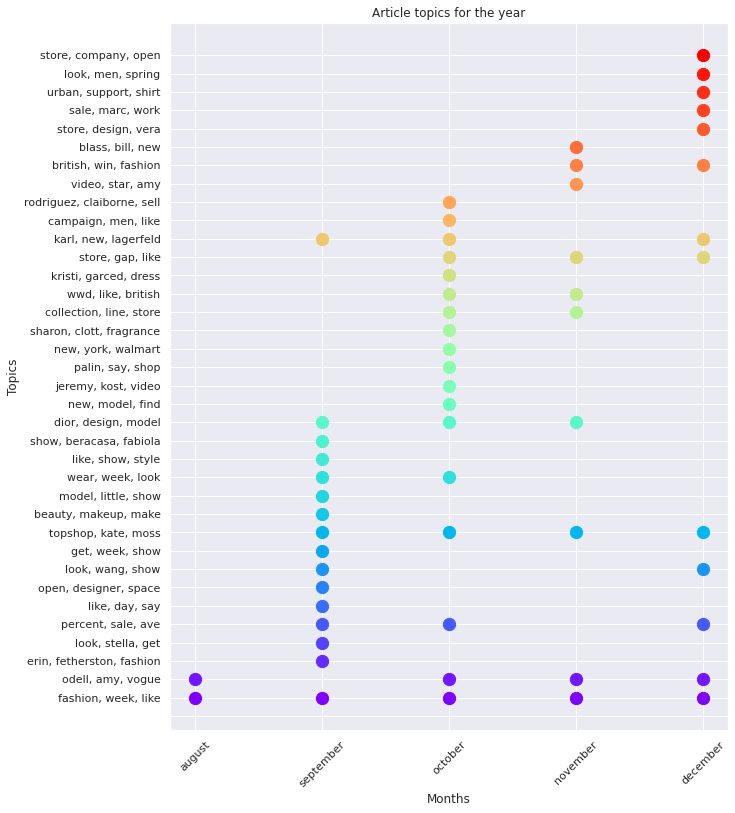

In [ ]:
names_months = ['august', 'september', 'october', 'november', 'december']
width = 10
height = 13
draw_graph(unique_topics, matrix, names_months, width, height)



---



**2009 год**

Количество уникальных тем за год: 89


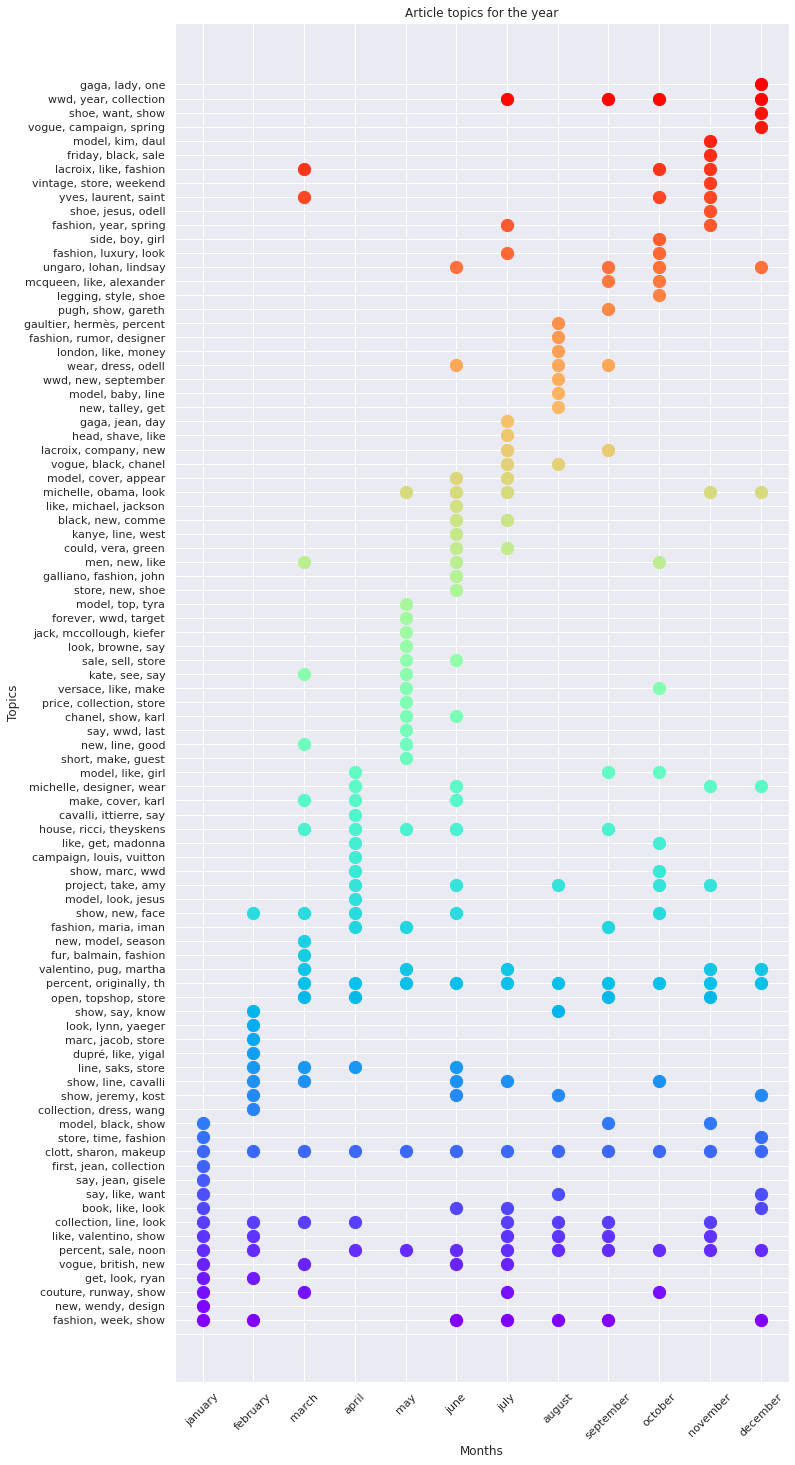

In [ ]:
topics_april = artm_model(df2009[0], 20)
topics_august = artm_model(df2009[1], 20)
topics_december = artm_model(df2009[2], 20)
topics_february = artm_model(df2009[3], 20)
topics_january = artm_model(df2009[4], 20)
topics_july = artm_model(df2009[5], 20)
topics_june = artm_model(df2009[6], 20)
topics_march = artm_model(df2009[7], 20)
topics_may = artm_model(df2009[8], 20)
topics_november = artm_model(df2009[9], 20)
topics_october = artm_model(df2009[10], 20)
topics_september = artm_model(df2009[11], 20)


threshold = 7

unique_topics, matrix = find_topics_create_matrix(threshold,
                                                  topics_january, topics_february, topics_march, topics_april, topics_may, topics_june, 
                                                  topics_july, topics_august, topics_september, topics_october, topics_november, topics_december)

print('Количество уникальных тем за год:', len(unique_topics))

names_months = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']
width = 11
height = 25
draw_graph(unique_topics, matrix, names_months, width, height)



---



**2010 год**

Количество уникальных тем за год: 90


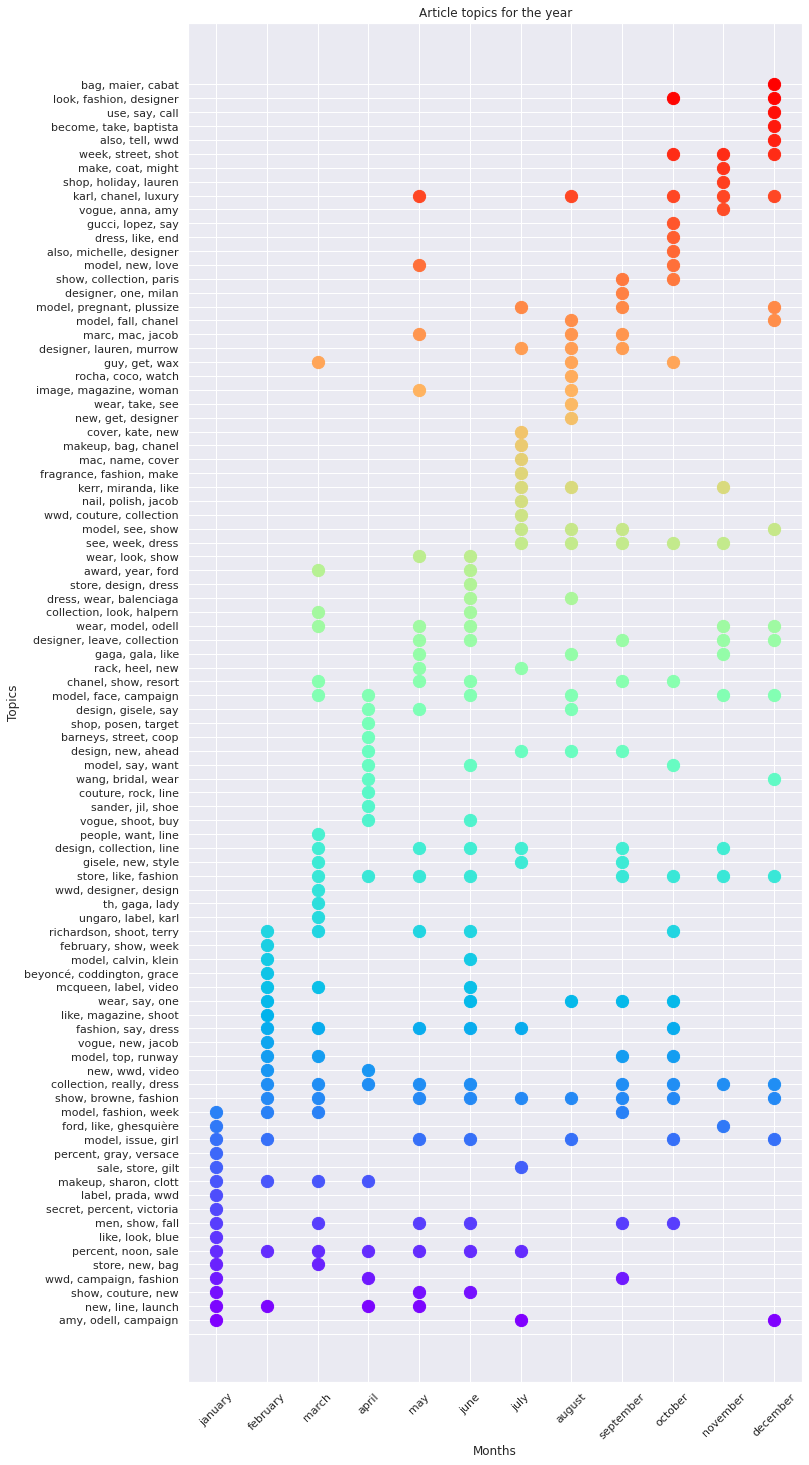

In [ ]:
topics_april = artm_model(df2010[0], 20)
topics_august = artm_model(df2010[1], 20)
topics_december = artm_model(df2010[2], 20)
topics_february = artm_model(df2010[3], 20)
topics_january = artm_model(df2010[4], 20)
topics_july = artm_model(df2010[5], 20)
topics_june = artm_model(df2010[6], 20)
topics_march = artm_model(df2010[7], 20)
topics_may = artm_model(df2010[8], 20)
topics_november = artm_model(df2010[9], 20)
topics_october = artm_model(df2010[10], 20)
topics_september = artm_model(df2010[11], 20)


threshold = 7

unique_topics, matrix = find_topics_create_matrix(threshold,
                                                  topics_january, topics_february, topics_march, topics_april, topics_may, topics_june, 
                                                  topics_july, topics_august, topics_september, topics_october, topics_november, topics_december)

print('Количество уникальных тем за год:', len(unique_topics))

names_months = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']
width = 11
height = 25
draw_graph(unique_topics, matrix, names_months, width, height)



---



**2012 год**

Количество уникальных тем за год: 87


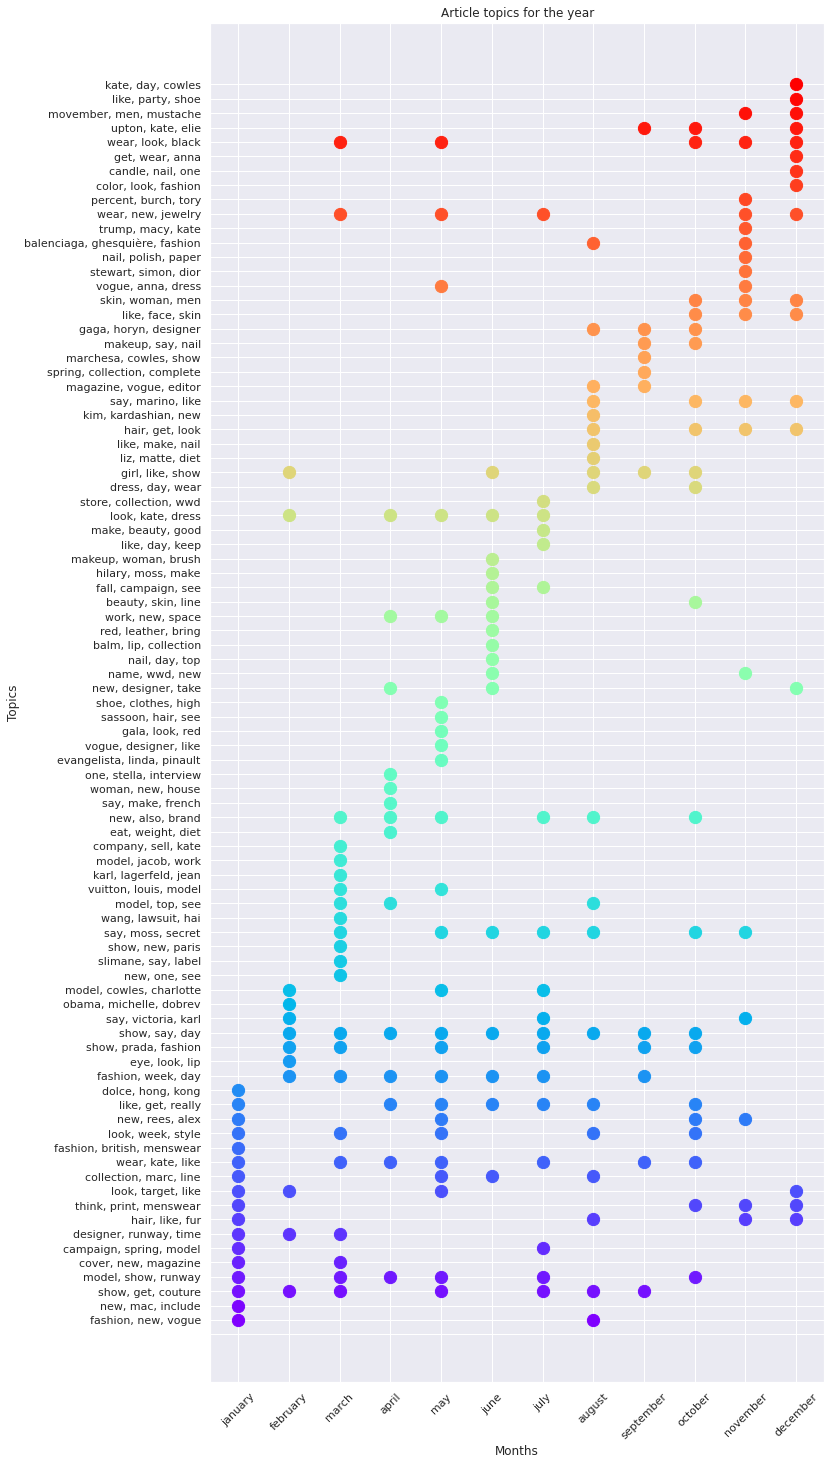

In [ ]:
topics_april = artm_model(df2012[0], 20)
topics_august = artm_model(df2012[1], 20)
topics_december = artm_model(df2012[2], 20)
topics_february = artm_model(df2012[3], 20)
topics_january = artm_model(df2012[4], 20)
topics_july = artm_model(df2012[5], 20)
topics_june = artm_model(df2012[6], 20)
topics_march = artm_model(df2012[7], 20)
topics_may = artm_model(df2012[8], 20)
topics_november = artm_model(df2012[9], 20)
topics_october = artm_model(df2012[10], 20)
topics_september = artm_model(df2012[11], 20)


threshold = 7

unique_topics, matrix = find_topics_create_matrix(threshold,
                                                  topics_january, topics_february, topics_march, topics_april, topics_may, topics_june, 
                                                  topics_july, topics_august, topics_september, topics_october, topics_november, topics_december)

print('Количество уникальных тем за год:', len(unique_topics))

names_months = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']
width = 11
height = 25
draw_graph(unique_topics, matrix, names_months, width, height)



---



**2013 год**

Количество уникальных тем за год: 84


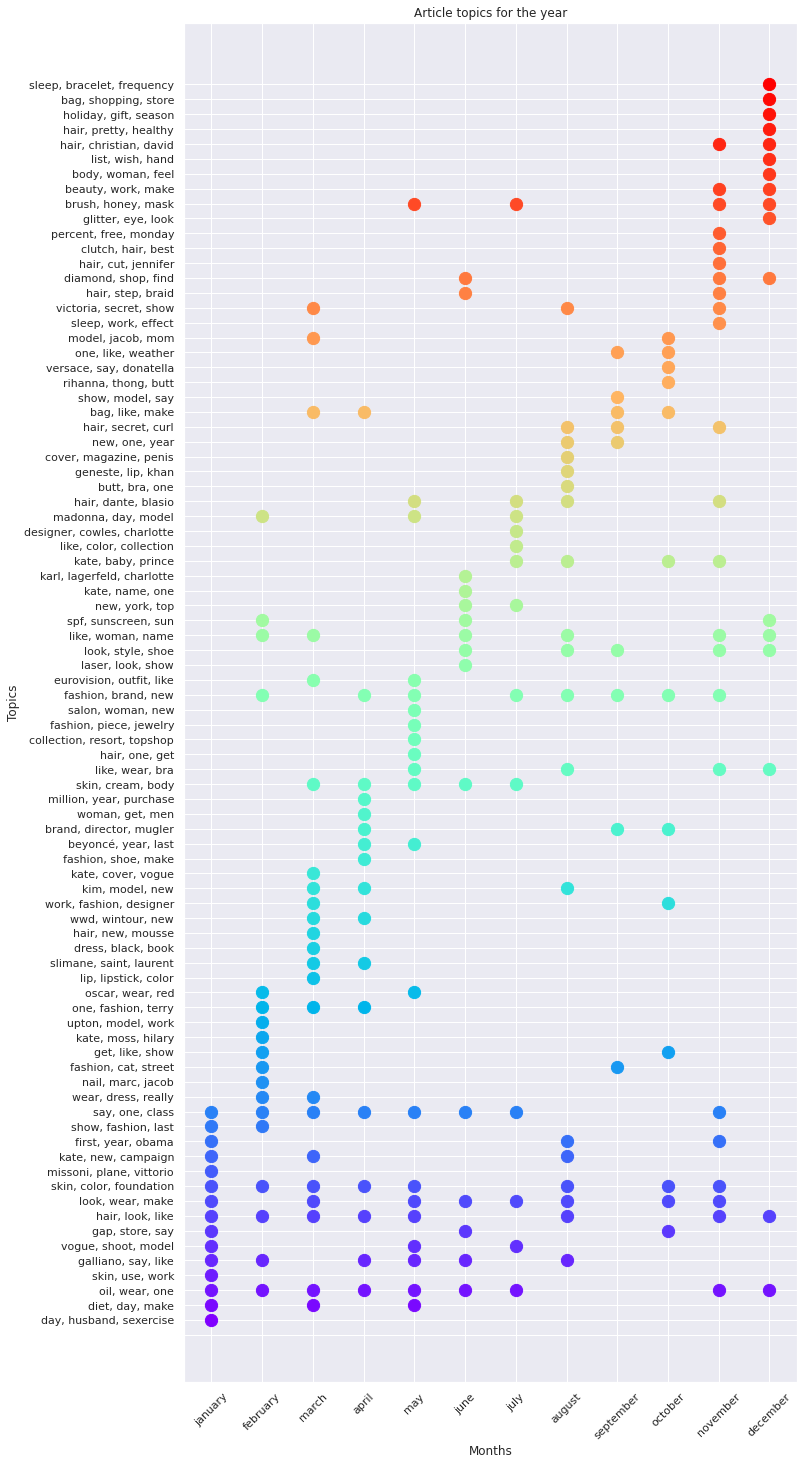

In [ ]:
topics_april = artm_model(df2013[0], 20)
topics_august = artm_model(df2013[1], 20)
topics_december = artm_model(df2013[2], 20)
topics_february = artm_model(df2013[3], 20)
topics_january = artm_model(df2013[4], 20)
topics_july = artm_model(df2013[5], 20)
topics_june = artm_model(df2013[6], 20)
topics_march = artm_model(df2013[7], 20)
topics_may = artm_model(df2013[8], 20)
topics_november = artm_model(df2013[9], 20)
topics_october = artm_model(df2013[10], 20)
topics_september = artm_model(df2013[11], 20)


threshold = 7

unique_topics, matrix = find_topics_create_matrix(threshold,
                                                  topics_january, topics_february, topics_march, topics_april, topics_may, topics_june, 
                                                  topics_july, topics_august, topics_september, topics_october, topics_november, topics_december)

print('Количество уникальных тем за год:', len(unique_topics))

names_months = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']
width = 11
height = 25
draw_graph(unique_topics, matrix, names_months, width, height)



---



**2014 год**

Количество уникальных тем за год: 108


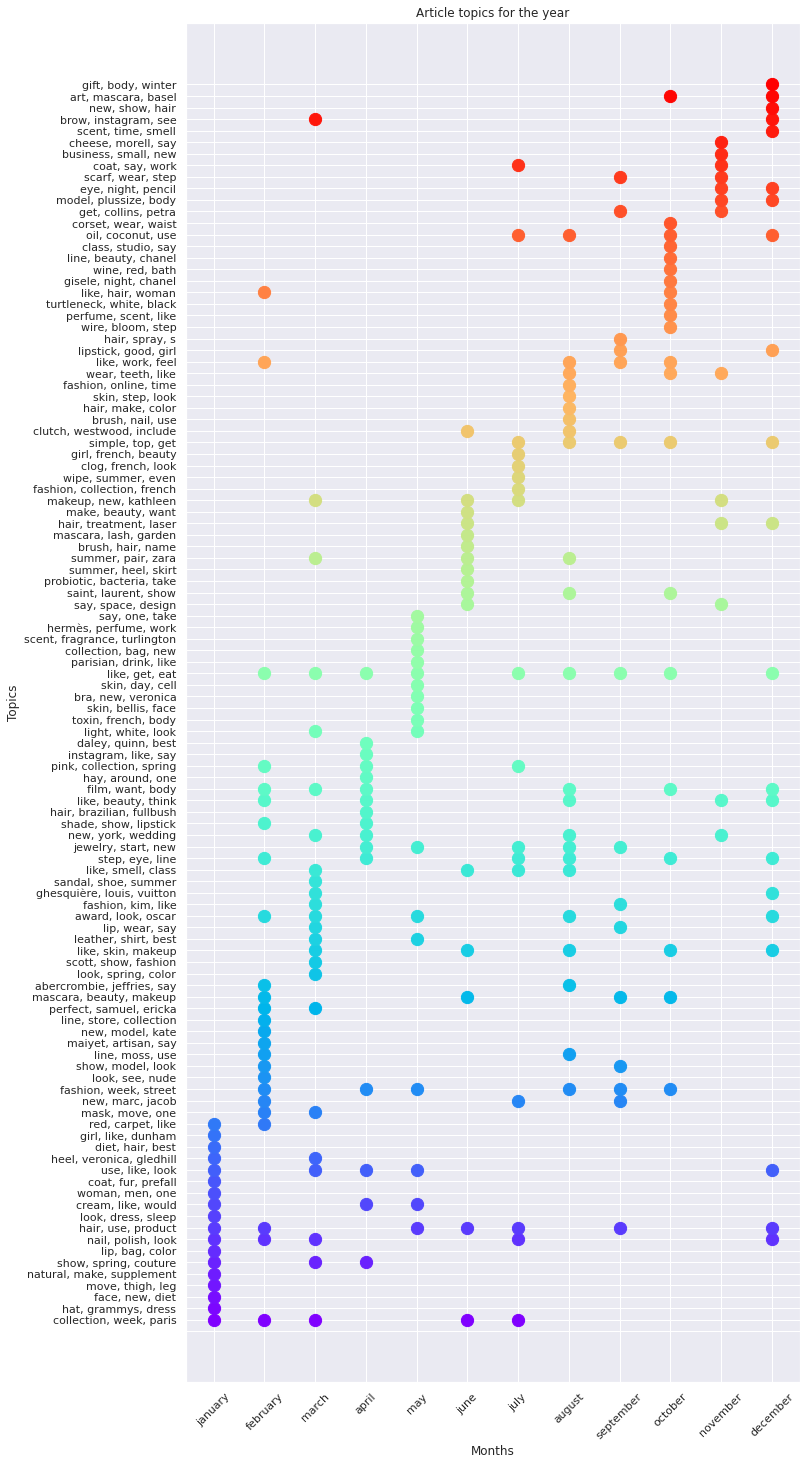

In [ ]:
topics_april = artm_model(df2014[0], 20)
topics_august = artm_model(df2014[1], 20)
topics_december = artm_model(df2014[2], 20)
topics_february = artm_model(df2014[3], 20)
topics_january = artm_model(df2014[4], 20)
topics_july = artm_model(df2014[5], 15)
topics_june = artm_model(df2014[6], 20)
topics_march = artm_model(df2014[7], 20)
topics_may = artm_model(df2014[8], 20)
topics_november = artm_model(df2014[9], 20)
topics_october = artm_model(df2014[10], 20)
topics_september = artm_model(df2014[11], 20)


threshold = 7

unique_topics, matrix = find_topics_create_matrix(threshold,
                                                  topics_january, topics_february, topics_march, topics_april, topics_may, topics_june, 
                                                  topics_july, topics_august, topics_september, topics_october, topics_november, topics_december)

print('Количество уникальных тем за год:', len(unique_topics))

names_months = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']
width = 11
height = 25
draw_graph(unique_topics, matrix, names_months, width, height)



---



**2015 год**

Количество уникальных тем за год: 98


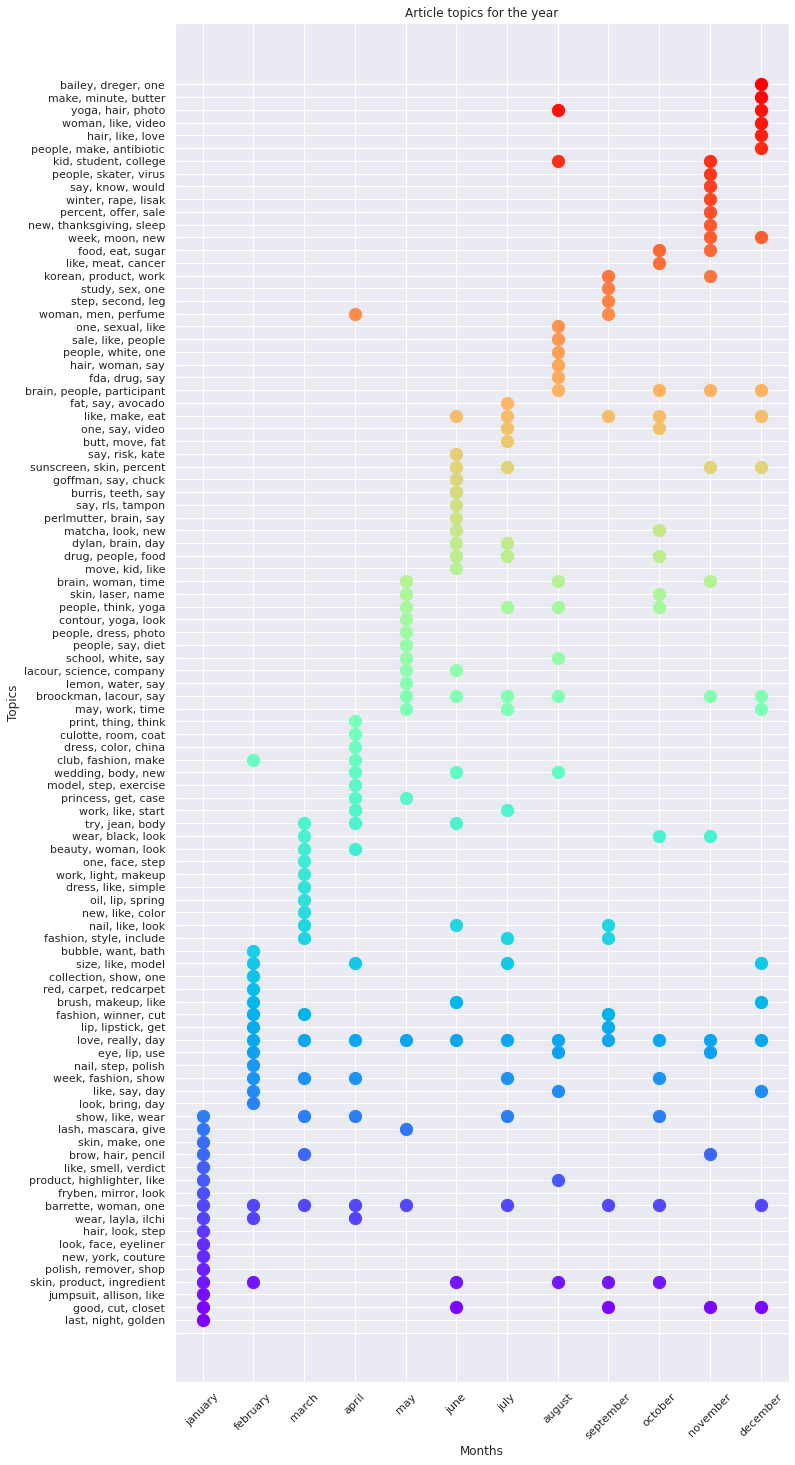

In [ ]:
topics_april = artm_model(df2015[0], 20)
topics_august = artm_model(df2015[1], 20)
topics_december = artm_model(df2015[2], 20)
topics_february = artm_model(df2015[3], 20)
topics_january = artm_model(df2015[4], 20)
topics_july = artm_model(df2015[5], 20)
topics_june = artm_model(df2015[6], 20)
topics_march = artm_model(df2015[7], 20)
topics_may = artm_model(df2015[8], 20)
topics_november = artm_model(df2015[9], 20)
topics_october = artm_model(df2015[10], 20)
topics_september = artm_model(df2015[11], 20)


threshold = 7

unique_topics, matrix = find_topics_create_matrix(threshold,
                                                  topics_january, topics_february, topics_march, topics_april, topics_may, topics_june, 
                                                  topics_july, topics_august, topics_september, topics_october, topics_november, topics_december)

print('Количество уникальных тем за год:', len(unique_topics))

names_months = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']
width = 11
height = 25
draw_graph(unique_topics, matrix, names_months, width, height)



---



**2016 год**

Количество уникальных тем за год: 57


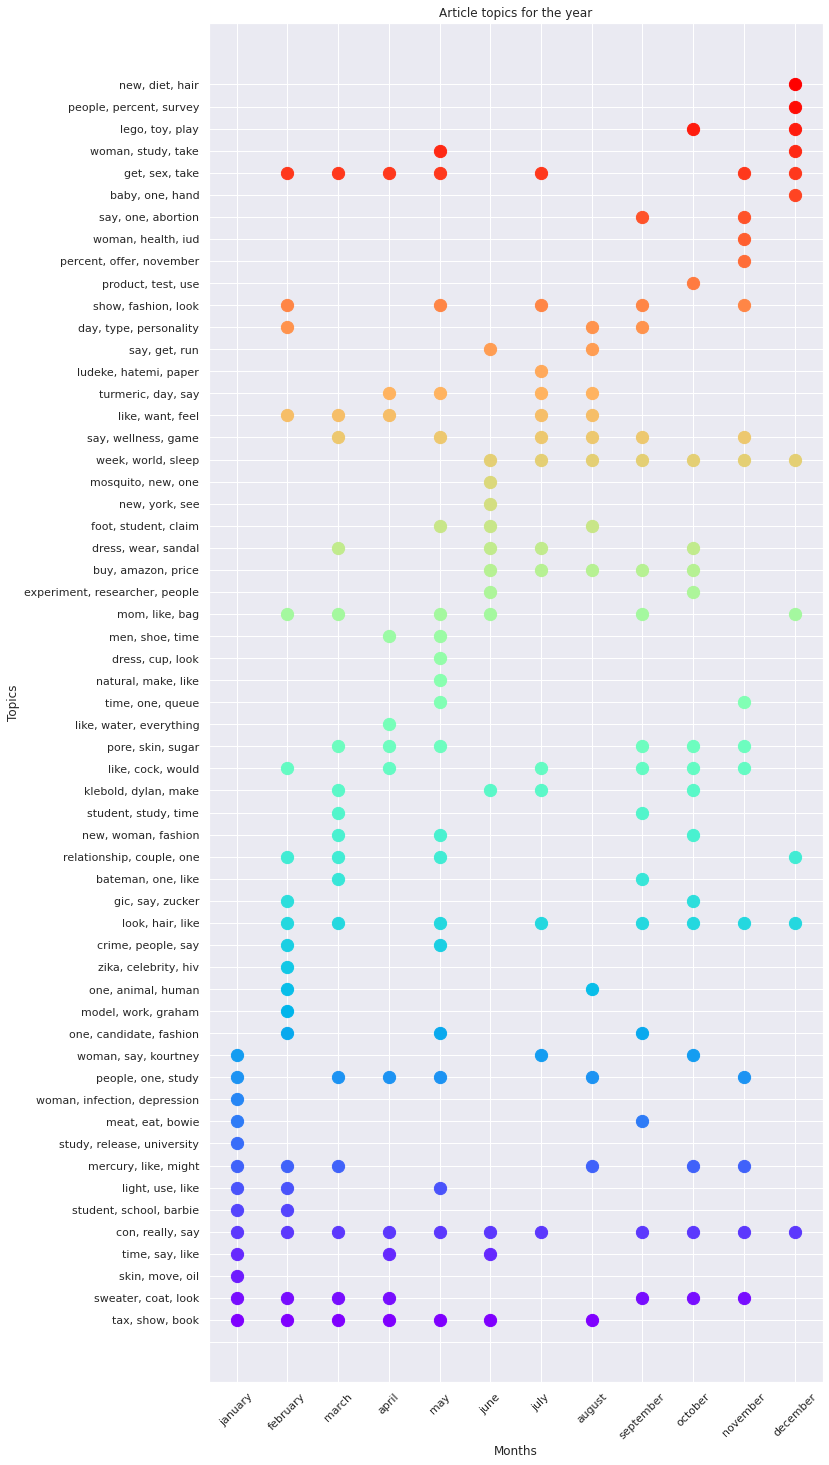

In [ ]:
topics_april = artm_model(df2016[0], 20)
topics_august = artm_model(df2016[1], 20)
topics_december = artm_model(df2016[2], 20)
topics_february = artm_model(df2016[3], 20)
topics_january = artm_model(df2016[4], 20)
topics_july = artm_model(df2016[5], 20)
topics_june = artm_model(df2016[6], 20)
topics_march = artm_model(df2016[7], 20)
topics_may = artm_model(df2016[8], 20)
topics_november = artm_model(df2016[9], 20)
topics_october = artm_model(df2016[10], 20)
topics_september = artm_model(df2016[11], 20)


threshold = 7

unique_topics, matrix = find_topics_create_matrix(threshold,
                                                  topics_january, topics_february, topics_march, topics_april, topics_may, topics_june, 
                                                  topics_july, topics_august, topics_september, topics_october, topics_november, topics_december)

print('Количество уникальных тем за год:', len(unique_topics))

names_months = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']
width = 11
height = 25
draw_graph(unique_topics, matrix, names_months, width, height)



---



**2017 год**

Количество уникальных тем за год: 54


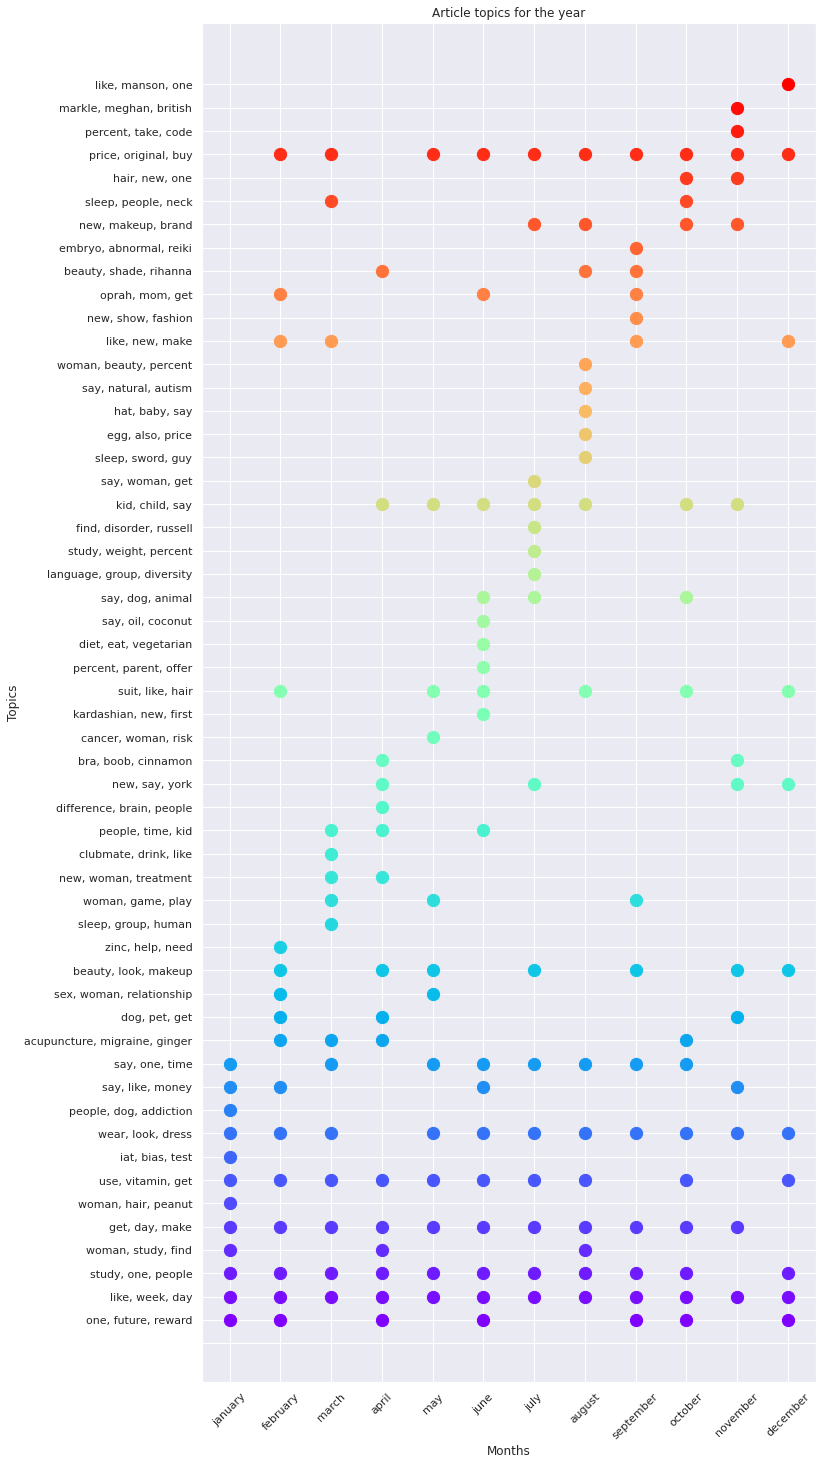

In [ ]:
topics_april = artm_model(df2017[0], 20)
topics_august = artm_model(df2017[1], 20)
topics_december = artm_model(df2017[2], 20)
topics_february = artm_model(df2017[3], 20)
topics_january = artm_model(df2017[4], 20)
topics_july = artm_model(df2017[5], 20)
topics_june = artm_model(df2017[6], 20)
topics_march = artm_model(df2017[7], 20)
topics_may = artm_model(df2017[8], 20)
topics_november = artm_model(df2017[9], 20)
topics_october = artm_model(df2017[10], 20)
topics_september = artm_model(df2017[11], 20)


threshold = 7

unique_topics, matrix = find_topics_create_matrix(threshold,
                                                  topics_january, topics_february, topics_march, topics_april, topics_may, topics_june, 
                                                  topics_july, topics_august, topics_september, topics_october, topics_november, topics_december)

print('Количество уникальных тем за год:', len(unique_topics))

names_months = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']
width = 11
height = 25
draw_graph(unique_topics, matrix, names_months, width, height)



---



**2018 год**

Количество уникальных тем за год: 31


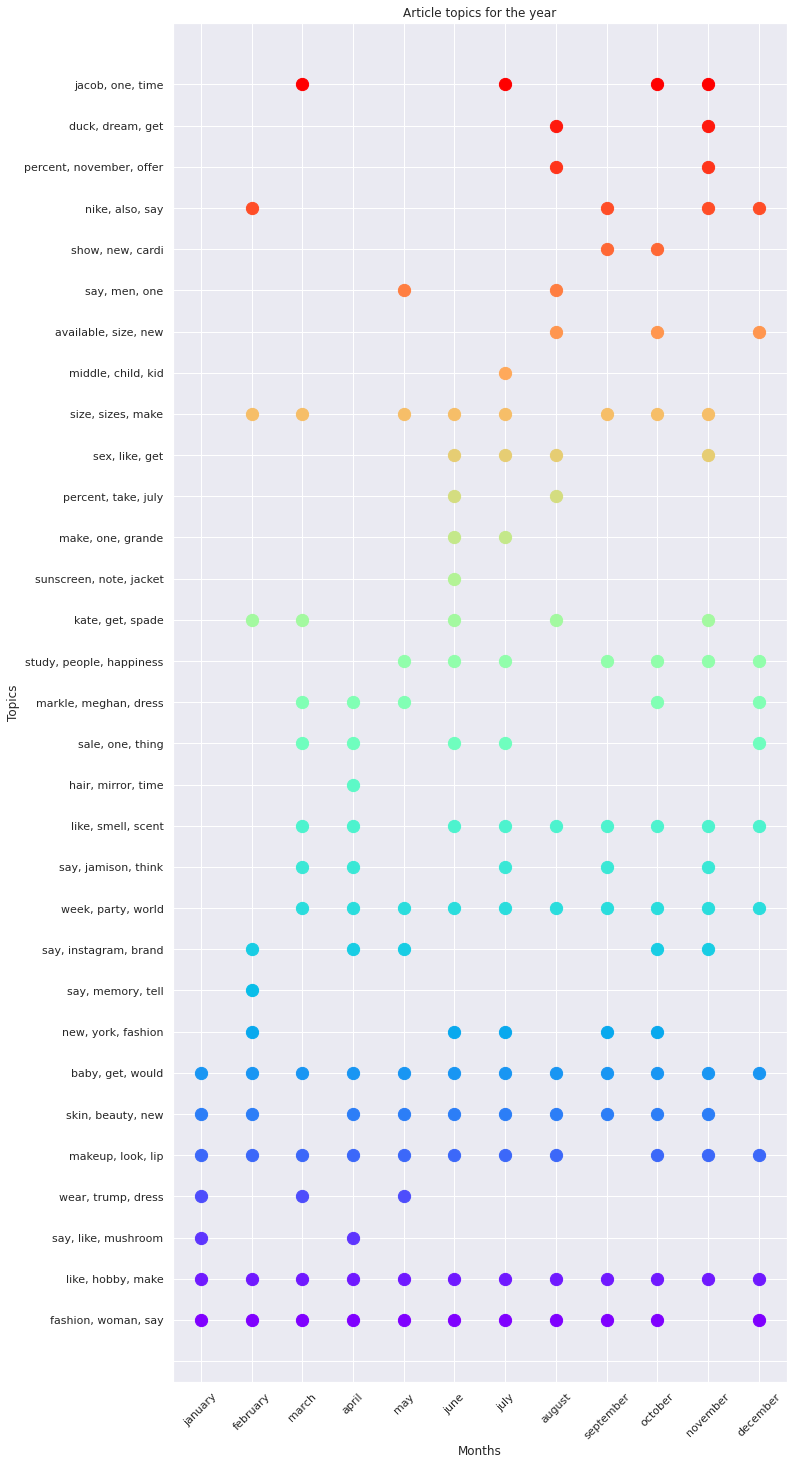

In [ ]:
topics_april = artm_model(df2018[0], 20)
topics_august = artm_model(df2018[1], 20)
topics_december = artm_model(df2018[2], 20)
topics_february = artm_model(df2018[3], 20)
topics_january = artm_model(df2018[4], 20)
topics_july = artm_model(df2018[5], 20)
topics_june = artm_model(df2018[6], 20)
topics_march = artm_model(df2018[7], 20)
topics_may = artm_model(df2018[8], 20)
topics_november = artm_model(df2018[9], 20)
topics_october = artm_model(df2018[10], 20)
topics_september = artm_model(df2018[11], 20)


threshold = 7

unique_topics, matrix = find_topics_create_matrix(threshold,
                                                  topics_january, topics_february, topics_march, topics_april, topics_may, topics_june, 
                                                  topics_july, topics_august, topics_september, topics_october, topics_november, topics_december)

print('Количество уникальных тем за год:', len(unique_topics))

names_months = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']
width = 11
height = 18
draw_graph(unique_topics, matrix, names_months, width, height)